In [7]:
import math
import lal
import lalsimulation as lalsim
import numpy as np
import matplotlib.pyplot as plt 
import random as rnd
import nlopt
import copy
import typing as typ
import dataclasses as datacl
import time 

from pycbc.filter import match as simple_match, optimized_match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform.utils import coalign_waveforms

# Análisis de los Parámetros Extrínsicos

In [8]:
def chirp_mass_function(masses:list)->float:

    return ((masses[0]*masses[1])**(3/5))/((masses[0]+masses[1])**(1/5))


def eff_spin_function(masses:list, spins:list)->float:

    return (spins[0]*masses[0]+spins[1]*masses[1])/(masses[0]+masses[1])

In [9]:
import lal
import math

class params: # Class with all the basic information mandatory to simulate a GW
    def __init__(self, masses:tuple, spin1:tuple = (0,0,0) ,spin2:tuple= (0,0,0), r: float = 1e6 * lal.PC_SI,
                  incl:float = 0, phiRef:float = 0, longAscNodes:float=0, ecc:float = 0, meanPerAno:float = 0):
        # Atributo de instancia (Se vincula a la instancia)
        self.m1: float = masses[0] # Mass of the first Black Hole
        self.m2: float = masses[1] # Mass of the second Black Hole
        self.s1x:float = spin1[0] # First Component of the dimensionless spin parameter of the first Black Hole
        self.s1y:float = spin1[1] # Second Component of the dimensionless spin parameter of the first Black Hole
        self.s1z:float = spin1[2] # Third Component of the dimensionless spin parameter of the first Black Hole
        self.s2x:float = spin2[0] # First Component of the dimensionless spin parameter of the second Black Hole
        self.s2y:float = spin2[1] # Second Component of the dimensionless spin parameter of the second Black Hole
        self.s2z:float = spin2[2] # Third Component of the dimensionless spin parameter of the second Black Hole
        self.distance:float = r # Distance to the binary system
        self.inclination:float = incl # Angle of inclination of the system with respect to the earth
        self.phiRef:float = phiRef
        self.longAscNodes:float = longAscNodes
        self.eccentricity:float = ecc # Eccentricity of the binary system
        self.meanPerAno : float = meanPerAno # Parameter for the simulation of a system with eccentricity

    def Q(self) -> float: # Chirp Mass of the binary system
        return self.m1/self.m2


    def chirp_mass(self) -> float: # Chirp Mass of the binary system
        return chirp_mass_function([self.m1, self.m2])
    

    def eff_spin(self) -> float: # Effective Spin Parameter of the binary system
        return eff_spin_function([self.m1, self.m2], [self.s1z, self.s2z])
    
    
    def spin1perp(self) -> float: # Module of the perpendicular component of the spin of the first black hole
        return math.sqrt(self.s1x**2+self.s1y**2)
    

    def anglespin1(self) -> float: # Angle of spin1x + i spin1y 
        return math.atan2(self.s1y, self.s1x) 


    def cambiar_valor_paso(self, n_param: int, h:float, a:float) -> None: # Function to sum a step to some parameter, useful to obtain the derivative
        param_keys = list(self.__dict__.keys())
        param_values = list(self.__dict__.values())
        atributo = param_keys[n_param]
        
        setattr(self, atributo, param_values[n_param]+a*h)

    def __str__(self) -> str: # String to format how does print(params) work
        return f"mass1: {self.m1} | mass2: {self.m2} | spin1: {self.s1x, self.s1y, self.s1z}| spin2: {self.s2x, self.s2y, self.s2z}, | distance: {self.distance}, |inclination: {self.inclination}, |phiRef: {self.phiRef}, |longAscNodes: {self.longAscNodes}, |eccentricity: {self.eccentricity}| meanPerAno: {self.meanPerAno}"
    

In [10]:
def simulationTD_IMRPhenomTPHM(parameters: params, delta_T:float, f_min:float, f_ref:float)->tuple:

    Approximant = "IMRPhenomTPHM"

    # Modes
    mode_list = [[2, 2], [2, -2]]

    # Create the waveform parameters structure
    waveform_params = lal.CreateDict()

    mode_array = lalsim.SimInspiralCreateModeArray()
    for l, m in mode_list:
        lalsim.SimInspiralModeArrayActivateMode(mode_array, l, m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(waveform_params, mode_array)


    with lal.no_swig_redirect_standard_output_error():
    # Generate the waveform
        hplus, hcross = lalsim.SimInspiralChooseTDWaveform(**parameters.__dict__,
        deltaT=delta_T, f_min=f_min, f_ref=f_ref, params=None, approximant=lalsim.GetApproximantFromString(Approximant)
        )

    # Extract time series for both plus (h_plus) and cross (h_cross) polarizations
    h_plus = hplus.data.data
    h_cross = hcross.data.data 
    time = np.arange(len(h_plus)) * delta_T

    return h_plus, h_cross, time # The data is returned as Numpy arrays, we lost information of the epoch, etc which we won't use in this example

In [11]:
def perform_match(hnr, hap, f_lower, f_high, optimized = False, return_phase = False)->tuple:
    FD = isinstance(hnr, FrequencySeries)
    if not FD: 
        hnr, hap = hnr.real(), hap.real()
    
    # Match signal sizes
    length = min(len(hnr), len(hap))
    hnr.resize(length); hap.resize(length)

    # Compute PSD
    if FD: 
        delta_f = hnr.delta_f
    else:
        delta_f = 1/hnr.duration
    
    psd = aLIGOZeroDetHighPower(length, delta_f, f_lower)
    
    # Compute Match
    match_kwargs = dict(vec1 = hnr, vec2 = hap, psd = psd, low_frequency_cutoff = f_lower, high_frequency_cutoff = f_high, return_phase = return_phase)
    return optimized_match(**match_kwargs) if optimized else simple_match(**match_kwargs, subsample_interpolation = True)

# Inclinacion

In [12]:
mass1_target = 100 * lal.MSUN_SI
mass2_target = 30 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0,0.9,0.0)
spin2_target = (0,0,0.0)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 10
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [13]:
incl_test = math.pi/2

parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, incl_test)

hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_test = TimeSeries(hp_test, delta_t=delta_T)

In [14]:
match,_ = perform_match (hp_target, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
print(1-match)

0.23437747617826354


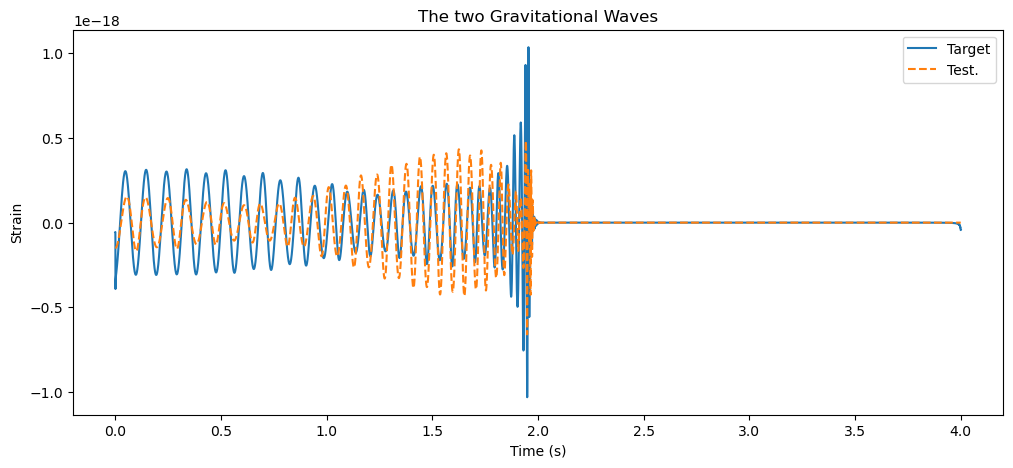

In [15]:
# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_test)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

La inclinacion afecta ***mucho*** cuando se incluyen los modos no dominantes. Parece tener simetría [0,pi]. Calculando el match entre un sistema binario con inclinacion 0 y otro con inclinacion pi/2 con todos los modos (waveform_params=None) obtenemos mismatch = 0,0014 (para Q=1). Por lo que parece un parámetro poco importante en la optimizacion. Aunque cambiando los parámetros del sistema tiene algo másde importantcia. Por ejemplo, aumentando a Q=20/3 obtenemos un mismatch = 0,13. Cambiar la tercera componente de spin de los agujeros negros no parece modificar mucho estos valores. Sin embargo, el spin en el eje x o y del agujero negro dominante si modifica mucho este valor. Para un Q=10/3 y S1x=0.9 obtenemos una diferencia un mismatch = 0,3 al fijar una inclinacion incl=0 o incl=pi/2.

# PhiRef

In [16]:
mass1_target = 150 * lal.MSUN_SI
mass2_target = 30 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0.7,0.7,0.0)
spin2_target = (0,0,0.9)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [17]:
import numpy as np
import math

phiRef_list = np.linspace(0, 2*math.pi, 360)

match_list = []
for phiRef_test in phiRef_list:

    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, phiRef=phiRef_test)

    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)

    # Convert the data obtained from a numpy array to a PyCBC TimeSeries
    hp_test = TimeSeries(hp_test, delta_t=delta_T)


    match,_ = perform_match (hp_target, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)

    match_list.append([match, phiRef_test])

In [18]:
max_match = 0
min_match = 1

for i in range(len(match_list)):
    if match_list[i][0]>max_match:
        max_match = match_list[i][0]
        max_i = i

    if match_list[i][0]<min_match:
        min_match = match_list[i][0]
        min_i = i

print(f"The worst match is {min_match} con un PhiRef {match_list[min_i][1]}")
print(f"The best match is {max_match} con un PhiRef {match_list[max_i][1]}")

The worst match is 0.5790688819676681 con un PhiRef 3.8504199654025317
The best match is 0.9999999999999999 con un PhiRef 0.0


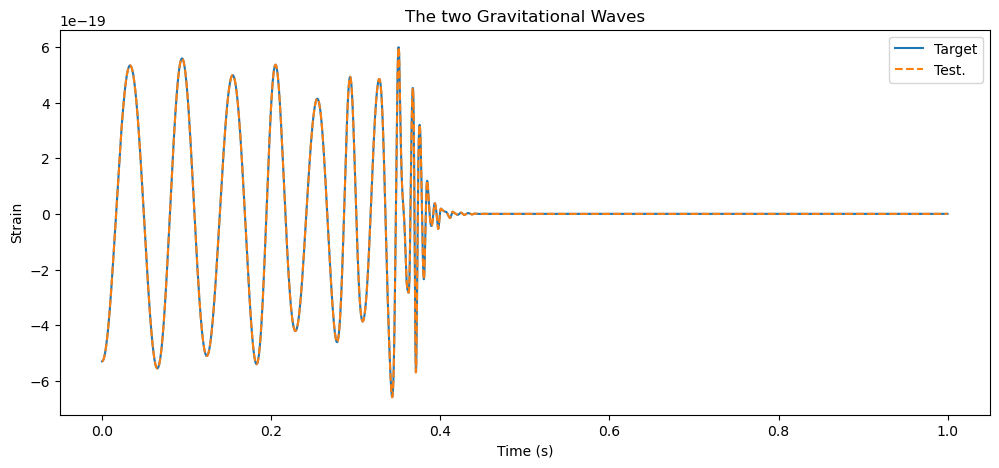

In [19]:
# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_test)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

Para PhiRef no veo muy bien que valores es típico que tenga. Utilizar el dominio [0,pi] o [0,2*pi] no parece cambiar tanto el resultado. Al igual que antes se nota más el mismatch para valores altos de Q. Quizá tenga que ver con las frecuencias mínimas? Ya que con valores altos de Q solo observamos el ringdown del sistema y no creo que sea la parte más predictiva del modelo. La mayor parte de la diferencia entre ambas ondas viene dada por el spin de precesion. PREGUNTAR

# LongAscNodes

In [20]:
mass1_target = 150 * lal.MSUN_SI
mass2_target = 30 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0.7,0.7,0.0)
spin2_target = (0,0,0.9)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [21]:
import numpy as np
import math

longAscNodes_list = np.linspace(0, 2*math.pi, 360)

match_list = []
for longAscNodes_test in longAscNodes_list:

    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, longAscNodes = longAscNodes_test)

    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)

    # Convert the data obtained from a numpy array to a PyCBC TimeSeries
    hp_test = TimeSeries(hp_test, delta_t=delta_T)


    match,_ = perform_match (hp_target, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)

    match_list.append([match, longAscNodes_test])

In [22]:
max_match = 0
min_match = 1

for i in range(len(match_list)):
    if match_list[i][0]>max_match:
        max_match = match_list[i][0]
        max_i = i

    if match_list[i][0]<min_match:
        min_match = match_list[i][0]
        min_i = i

print(f"The worst match is {min_match} con un LongAscNodes {match_list[min_i][1]}")
print(f"The best match is {max_match} con un LongAscNodes {match_list[max_i][1]}")

The worst match is 0.5790688819676685 con un LongAscNodes 2.432765341777054
The best match is 0.9999999999999999 con un LongAscNodes 0.0


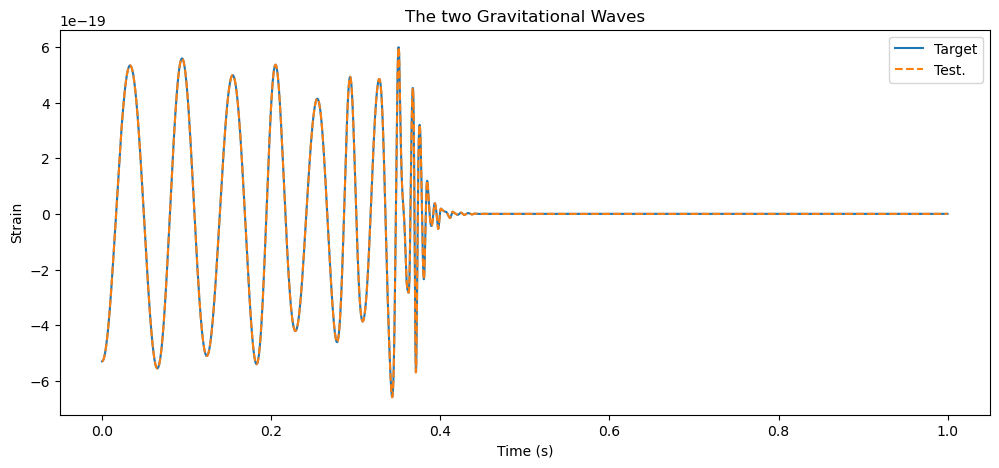

In [23]:
# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_test)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

Parecido a la anterior.

# Eccentricity

In [24]:
mass1_target = 50 * lal.MSUN_SI
mass2_target = 10 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0,0.0,0.9)
spin2_target = (0,0,0.9)

parameters_target:params = params(masses_target, spin1_target, spin2_target, r_target)
delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [25]:
ecc_test = 0.99

parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, ecc=ecc_test)

hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)

# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_test = TimeSeries(hp_test, delta_t=delta_T)


match,_ = perform_match (hp_target, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
print(1-match)

2.220446049250313e-16


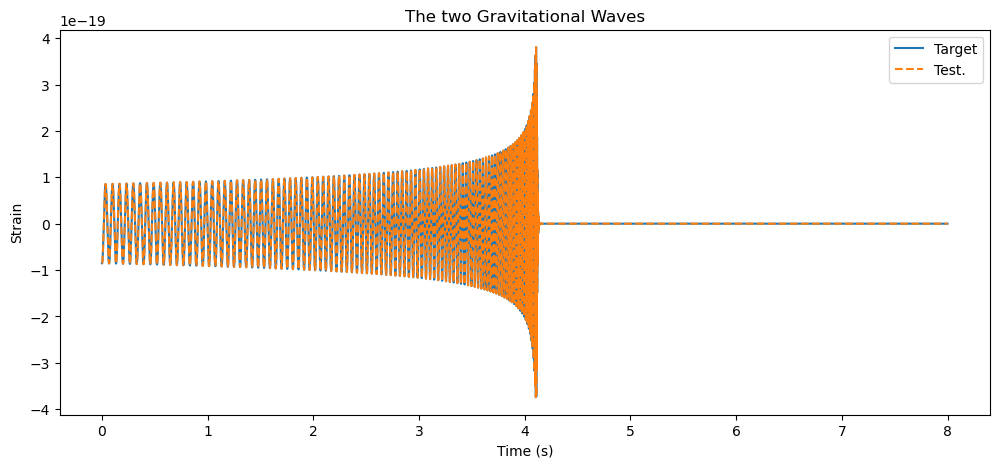

In [26]:
# Waveforms Coaligned 
h1_aligned, h2_aligned = coalign_waveforms(hp_target, hp_test)

# Plot of the coaligned waveforms
plt.figure(figsize=(12, 5))
plt.plot(h1_aligned.sample_times, h1_aligned, label = f'Target')
plt.plot(h2_aligned.sample_times, h2_aligned, label = f'Test.', linestyle='dashed')
plt.title(f'The two Gravitational Waves')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.show()

No parece estar implementado en el modelo, como me dijo Sascha.

# Plotting match against Inclination, PhiRef and LongAscNodes

First, we plot these graphics independently, so we create three independent 1D grids. Later, we'll try to see what happens if we create a 3D grid an combine the parameters.

In [27]:
#TARGET

mass1_target = 150 * lal.MSUN_SI
mass2_target = 30 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0.7,0.7,0.0)
spin2_target = (0,0,0.9)


incl_target = math.pi/2
PhiRef_target = 0
LongAscNodes_target = math.pi/4
parameters_target_incl:params = params(masses_target, spin1_target, spin2_target, r_target, incl = incl_target)
parameters_target_PhiRef:params = params(masses_target, spin1_target, spin2_target, r_target, phiRef = PhiRef_target)
parameters_target_LongAscNodes:params = params(masses_target, spin1_target, spin2_target, r_target, longAscNodes = LongAscNodes_target)

delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target_incl, delta_T, f_min, f_ref)
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target_incl = TimeSeries(hp_target, delta_t=delta_T)

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target_PhiRef, delta_T, f_min, f_ref)
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target_PhiRef = TimeSeries(hp_target, delta_t=delta_T)

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target_LongAscNodes, delta_T, f_min, f_ref)
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target_LongAscNodes = TimeSeries(hp_target, delta_t=delta_T)


In [28]:
N = 100

incl_grid = np.linspace(0, 2*math.pi, N)
PhiRef_grid = np.linspace(0, 2*math.pi, N)
LongAscNodes_grid = np.linspace(0, 2*math.pi, N)


match_incl = []
match_PhiRef = []
match_LongAscNodes = []
match_both = []
    

#### Incl

In [29]:
for i in range(N):

    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, incl = incl_grid[i])
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
    hp_test = TimeSeries(hp_test, delta_t=delta_T)

    match,_ = perform_match (hp_target_incl, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_incl.append(match)

#### PhiRef

In [30]:
for i in range(N):

    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, phiRef = PhiRef_grid[i])
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
    hp_test = TimeSeries(hp_test, delta_t=delta_T)

    match,_ = perform_match (hp_target_PhiRef, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_PhiRef.append(match)

#### LongAscNodes

In [31]:
for i in range(N):

    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, longAscNodes = LongAscNodes_grid[i])
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
    hp_test = TimeSeries(hp_test, delta_t=delta_T)

    match,_ = perform_match (hp_target_LongAscNodes, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_LongAscNodes.append(match)

#### PhiRef and LongAscNodes

In [32]:
masses_target=(151*lal.MSUN_SI, 29*lal.MSUN_SI)
spin1_target=(0.72,0.67,0.5)
spin1_target=(0.0,0.0,0.95)

for i in range(N):

    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, incl=2*math.pi/3, phiRef=PhiRef_grid[i], longAscNodes = LongAscNodes_grid[i])
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
    hp_test = TimeSeries(hp_test, delta_t=delta_T)

    match,_ = perform_match (hp_target_LongAscNodes, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_both.append(match)

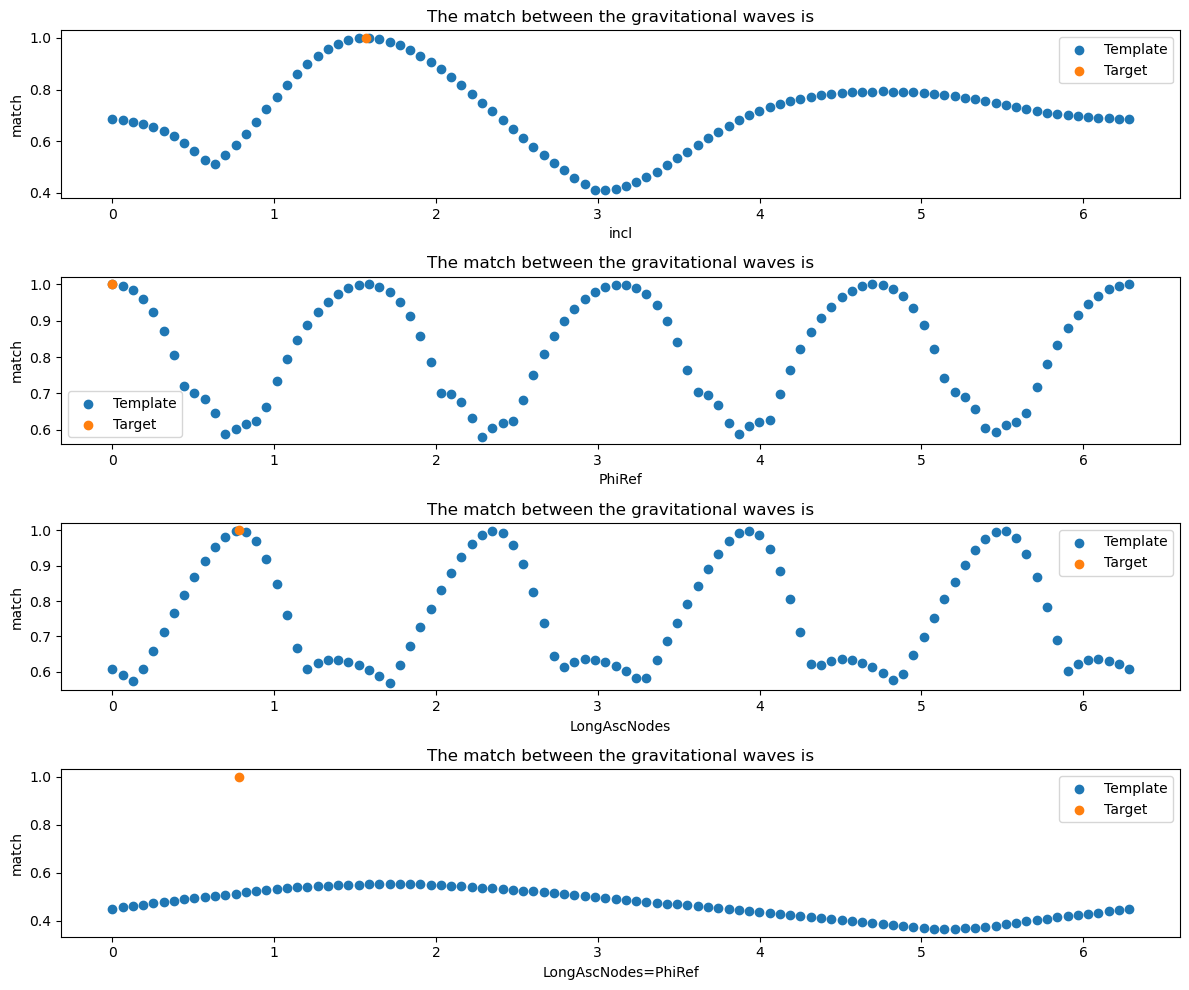

In [33]:
# Plot 
plt.figure(figsize=(12,10))
plt.subplot(4, 1, 1)
plt.scatter(incl_grid,np.array(match_incl), label = f'Template')
plt.scatter(incl_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('incl')
plt.ylabel('match')
plt.legend()

plt.subplot(4, 1, 2)
plt.scatter(PhiRef_grid,np.array(match_PhiRef), label = f'Template')
plt.scatter(PhiRef_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('PhiRef')
plt.ylabel('match')
plt.legend()

plt.subplot(4, 1, 3)
plt.scatter(LongAscNodes_grid,np.array(match_LongAscNodes), label = f'Template')
plt.scatter(LongAscNodes_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('LongAscNodes')
plt.ylabel('match')
plt.legend()

plt.subplot(4, 1, 4)
plt.scatter(LongAscNodes_grid,np.array(match_both), label = f'Template')
plt.scatter(LongAscNodes_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('LongAscNodes=PhiRef')
plt.ylabel('match')
plt.legend()

plt.tight_layout()
plt.show()

## PhiRef and LongAscNodes simultaneaously

In [34]:
#TARGET

mass1_target = 150 * lal.MSUN_SI
mass2_target = 30 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0.7,0.7,0.0)
spin2_target = (0,0,0.9)

PhiRef_target = 3*math.pi/4
LongAscNodes_target = 3*math.pi/2

parameters_target_LongAscNodes:params = params(masses_target, spin1_target, spin2_target, r_target, phiRef = PhiRef_target, longAscNodes = LongAscNodes_target)

delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target_LongAscNodes, delta_T, f_min, f_ref)
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [35]:
N = 50

PhiRef_grid = np.linspace(0, 2*math.pi, N)
LongAscNodes_grid = np.linspace(0, 2*math.pi, N)


match_PhiRef = []
match_LongAscNodes = []

In [36]:
match_plot = []
PhiRef_plot = []
LongAscNodes_plot = []

for i in range(N): # PhiRef
    for j in range(N): # LongAscNodes

        parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, phiRef = PhiRef_grid[i], longAscNodes = LongAscNodes_grid[j])
        hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
        hp_test = TimeSeries(hp_test, delta_t=delta_T)

        match,_ = perform_match (hp_target_PhiRef, hp_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
        match_plot.append(match)
        PhiRef_plot.append(PhiRef_grid[i])
        LongAscNodes_plot.append(LongAscNodes_grid[j])

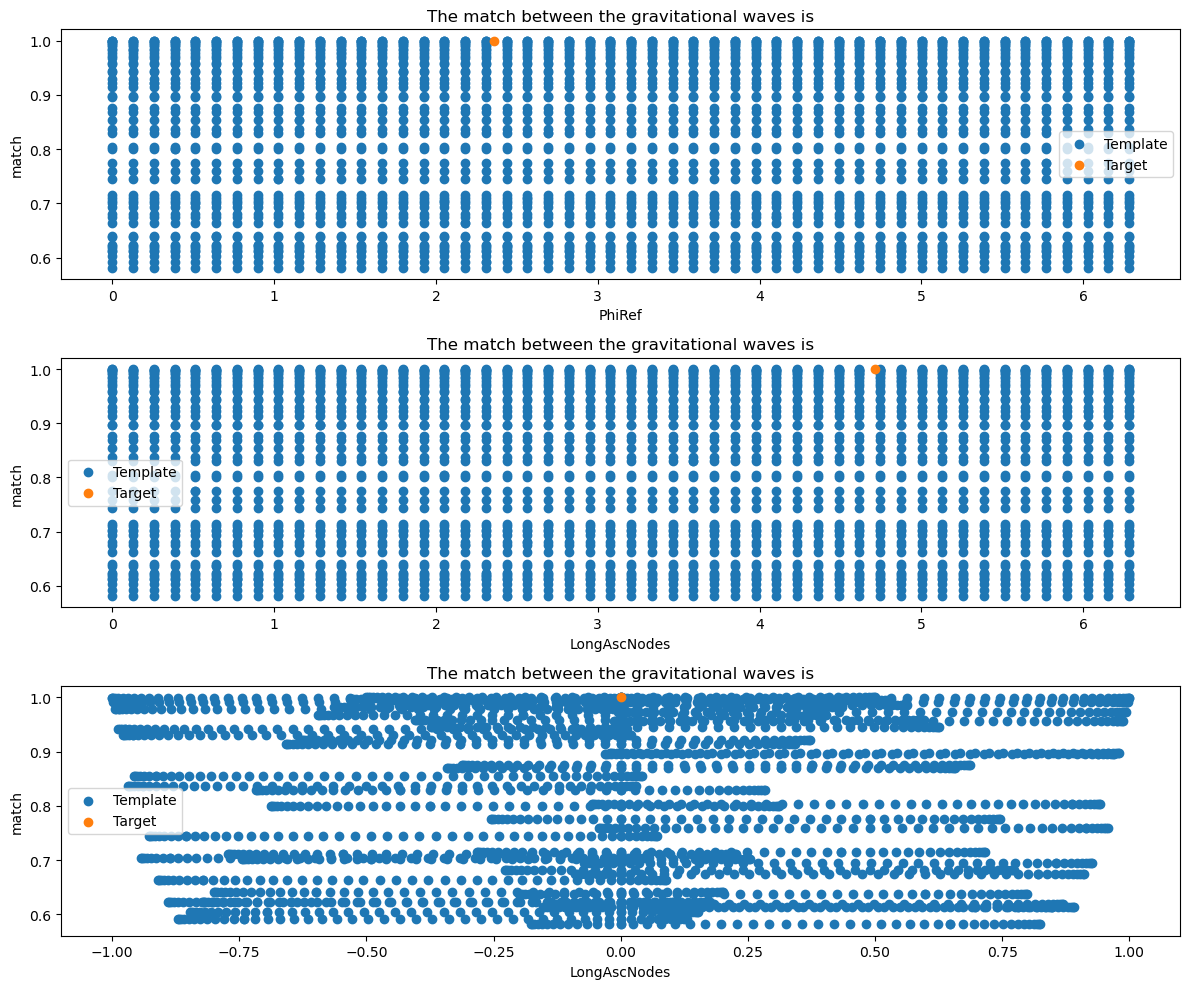

In [37]:
plot=[]
for i in range(N):
    for j in range(N):

        plot.append(math.cos(PhiRef_grid[i])*math.sin(LongAscNodes_grid[j]))
plot=np.array(plot)

# Plot 
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1)
plt.scatter(np.array(PhiRef_plot), np.array(match_plot), label = f'Template')
plt.scatter(PhiRef_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('PhiRef')
plt.ylabel('match')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(np.array(LongAscNodes_plot),np.array(match_plot), label = f'Template')
plt.scatter(LongAscNodes_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('LongAscNodes')
plt.ylabel('match')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(plot,np.array(match_plot), label = f'Template')
plt.scatter(math.cos(PhiRef_target)*math.cos(LongAscNodes_target), 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('LongAscNodes')
plt.ylabel('match')
plt.legend()


plt.tight_layout()
plt.show()

# Spin1 Precession

In [38]:
#TARGET

mass1_target = 70 * lal.MSUN_SI
mass2_target = 35 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0.7,0.7,0.0)
spin2_target = (0,0,0.9)

parameters_target = params(masses_target, spin1_target, spin2_target, r_target)

delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)

In [39]:
N = 100

spin1perp_grid = np.linspace(0, 1, N)
anglespin1_grid = np.linspace(-math.pi, math.pi, N)

match_spin1perp = []
match_anglespin1 = []
    

In [40]:
for i in range(N):

    spin1x = spin1perp_grid[i]*math.cos(parameters_target.anglespin1())
    spin1y = spin1perp_grid[i]*math.sin(parameters_target.anglespin1())

    spin1 = (spin1x, spin1y, parameters_target.s1z)

    parameters_test:params = params(masses_target, spin1, spin2_target, r_target)
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
    hp_test_spin1perp = TimeSeries(hp_test, delta_t=delta_T)

    match,_ = perform_match (hp_target, hp_test_spin1perp, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_spin1perp.append(match)


for i in range(N):

    spin1x = parameters_target.spin1perp()*math.cos(anglespin1_grid[i])
    spin1y = parameters_target.spin1perp()*math.sin(anglespin1_grid[i])

    spin1 = (spin1x, spin1y, parameters_target.s1z)

    parameters_test:params = params(masses_target, spin1, spin2_target, r_target)
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)
    hp_test_anglespin1 = TimeSeries(hp_test, delta_t=delta_T)

    match,_ = perform_match (hp_target, hp_test_anglespin1, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_anglespin1.append(match)

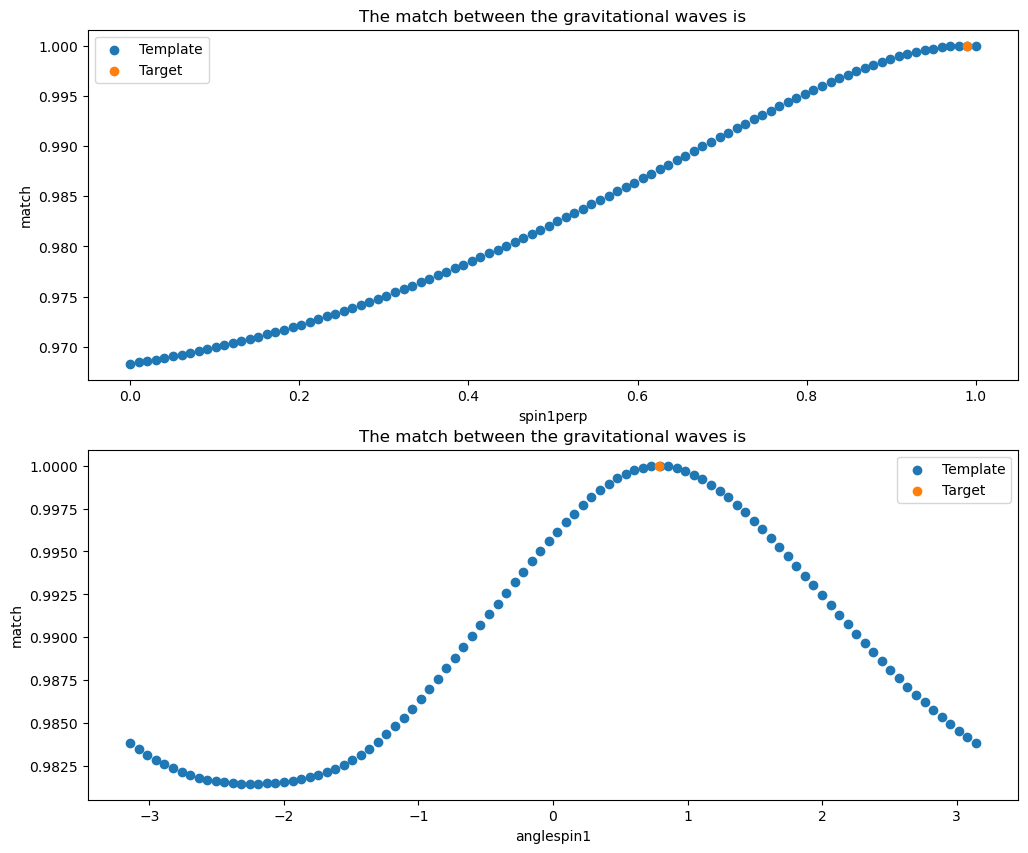

In [41]:
# Plot 
plt.figure(figsize=(12,10))

plt.subplot(2, 1, 1)
plt.scatter(np.array(spin1perp_grid), np.array(match_spin1perp), label = f'Template')
plt.scatter(parameters_target.spin1perp(), 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('spin1perp')
plt.ylabel('match')
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(np.array(anglespin1_grid),np.array(match_anglespin1), label = f'Template')
plt.scatter(parameters_target.anglespin1(), 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('anglespin1')
plt.ylabel('match')
plt.legend()

# Polarization

In [49]:
#TARGET

mass1_target = 70 * lal.MSUN_SI
mass2_target = 35 * lal.MSUN_SI

masses_target = (mass1_target, mass2_target)
r_target = 1e6 * lal.PC_SI
spin1_target = (0.7,0.7,0.0)
spin2_target = (0,0,0.9)

incl_target = math.pi/3
LongAscNodes_target = math.pi/4
pol_target = math.pi/4

parameters_target = params(masses_target, spin1_target, spin2_target, r_target, incl = incl_target, longAscNodes=LongAscNodes_target)

delta_T = 1.0/4096.0 
f_min = 15
f_max = 250
f_ref = f_min

hp_target, hc_target, time_target = simulationTD_IMRPhenomTPHM(parameters_target, delta_T, f_min, f_ref)
# Convert the data obtained from a numpy array to a PyCBC TimeSeries
hp_target = TimeSeries(hp_target, delta_t=delta_T)
hc_target = TimeSeries(hc_target, delta_t=delta_T)

h_target = hp_target*np.cos(2*pol_target) + hc_target*np.sin(2*pol_target) 

In [50]:
N = 200

polarization_grid = np.linspace(0, 2*math.pi, N)


match_pol = []

for i in range(N):


    parameters_test:params = params(masses_target, spin1_target, spin2_target, r_target, incl=incl_target, longAscNodes=LongAscNodes_target)
    hp_test, hc_test, time_test = simulationTD_IMRPhenomTPHM(parameters_test, delta_T, f_min, f_ref)

    hp_test = TimeSeries(hp_test, delta_t=delta_T)
    hc_test = TimeSeries(hc_test, delta_t=delta_T)

    h_test = hp_test*np.cos(2*polarization_grid[i]) + hc_test*np.sin(2*polarization_grid[i])

    match,_ = perform_match (h_target, h_test, f_lower=f_min, f_high=f_max, optimized = False, return_phase = False)
    match_pol.append(match)


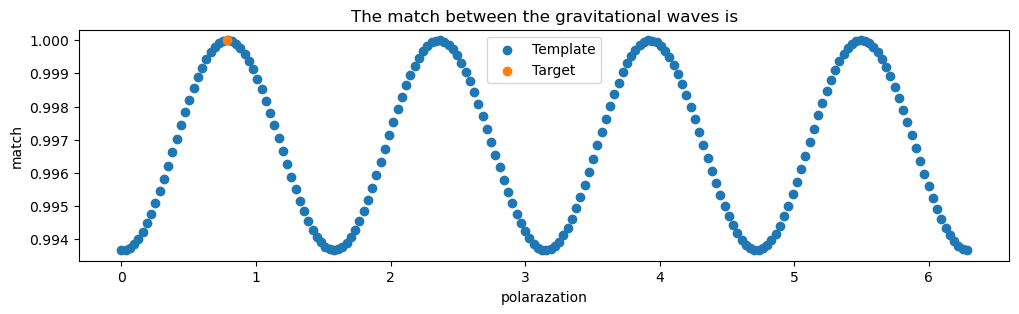

In [51]:
# Plot 
plt.figure(figsize=(12,3))

plt.scatter(np.array(polarization_grid), np.array(match_pol), label = f'Template')
plt.scatter(pol_target, 1, label = f'Target')
plt.title(f'The match between the gravitational waves is')
plt.xlabel('polarazation')
plt.ylabel('match')
plt.legend()